# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

# 1. Introduction



Welcome to my Jupyter notebook for the Kaggle competition "House Prices - Advanced Regression Techniques". In this competition, the goal is to predict the sale prices of homes based on a variety of features. This project provides an opportunity to practice advanced regression techniques, feature engineering, and model evaluation.

### Objective

The objective of this competition is to develop a regression model that accurately predicts the sale prices of houses. To achieve this, we'll perform exploratory data analysis, preprocess the dataset, engineer relevant features, train various regression models, and evaluate their performace.

### Dataset Overview

The dataset provided for this competition contains information about various attributes of residential homes. It includes features such as square footage, number of bedrooms, location, and more. Additionally, the dataset contains the target variable, which is the sale price of eac house.

### Tools and Libraries Used

- Python
- Pandas for data manipulation
- Matplotlib and Seaborn for data visualization
- Scikit-learn for model building and evaluation

Now, let's start by loading and exploring the dataset to gain a better understanding of the features and their relationships with the target variable.


# 2. Data Exploration and Preprocessing

## Loading the dataset

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('data_downloaded/train.csv')

## Exploring the dataset

In [25]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

### Check for Missing Values

In [27]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [28]:
len(missing_values)

19

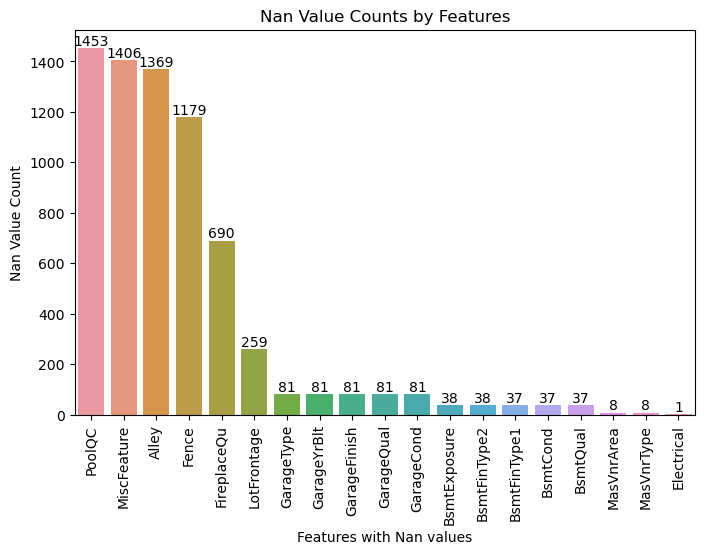

In [29]:
plt.figure(figsize=(8,5)) 
ax = sns.barplot(x=missing_values.index, y=missing_values.values)

plt.xticks(rotation=90)
plt.xlabel('Features with Nan values')
plt.ylabel('Nan Value Count')
plt.title('Nan Value Counts by Features')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

**Firstly**, we need to drop ID column, because it has unique values and results in high cardinality  
**Secondly**, we are checking any low cardinality issues, for example if there was only one value in a feature, it wouldnt effect the model  

We may need to check cardinality and collinearity issues later, but drop the obvious ones instantly

In [30]:
# Firstly
df.nunique().sort_values().nlargest(5)

Id           1460
LotArea      1073
GrLivArea     861
BsmtUnfSF     780
1stFlrSF      753
dtype: int64

In [31]:
# Secondly
df.nunique().sort_values().nsmallest(5)

CentralAir      2
Utilities       2
Street          2
Alley           2
BsmtHalfBath    3
dtype: int64

As we see above Pool quality, Miscellaneous features, Alley, Fence columns have too much nan values, therefore doesnt have significant importance and meaning to the dataset, So we have decided to **drop these columns**.  

Arguable we also decide to drop Fireplace quality column as well having almost %50 missing values.  

We also want to drop Id column, since they are all unique items - non collinearity

In [32]:
# 6 columns to drop
df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id'], inplace=True)

In [33]:
fillable_nan_features = list(df.isnull().sum()[df.isnull().sum() > 0].index)
fillable_nan_features

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [34]:
df[fillable_nan_features].dtypes

LotFrontage     float64
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object

In [35]:
# fill 2 float columns with columns' mean value
list_columns_mean = ['LotFrontage', 'MasVnrArea']

In [36]:
# other float value is 'GarageYrBlt' column. filling it with mean is nonsense, however it may have a relationship woth yearbuilt
df[['GarageYrBlt', 'YearBuilt']].corr()

GarageYrBlt  YearBuilt
GarageYrBlt     1.000000   0.825667
YearBuilt       0.825667   1.000000

In [37]:
# since there is a strong correlation with year built, we can drop garagebuilt feautre, it may result in noncollinearity
df.drop(columns=['GarageYrBlt'], inplace=True)

In [38]:
# other missing value columns are all object dtype and one by one they are suitable to be filled my mode
list_columns_mode = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' , 'GarageType', 'GarageFinish', 
                     'GarageQual', 'GarageCond', 'MasVnrType', 'Electrical' ]

**Now, lets define a function and fill out missing values:** 

In [39]:
def fill_missing_values(df, list_columns_mean=None, list_columns_median=None, list_columns_mode=None):
    '''
    this function takes three parameters
    df = the whole dataframe (pd.DataFrame)
    list_columns_mean = column names in a list to be filled with mean, e.g. = ['Area', 'Price']
    list_columns_mode = column names in a list to be filled with mode
    list_columns_median = column names in a list to be filled with median
    
    Returns:
    pd.DataFrame: The DataFrame with missing values filled.
    '''
    
    if list_columns_mean:
        for column in list_columns_mean:
            df[column] = df[column].fillna(df[column].mean())

    if list_columns_median:
        for column in list_columns_median:
            df[column] = df[column].fillna(df[column].median())

    if list_columns_mode:
        for column in list_columns_mode:
            df[column] = df[column].fillna(df[column].mode()[0])

    return df    

In [40]:
df = fill_missing_values(df, list_columns_mean=list_columns_mean, list_columns_median=None, list_columns_mode=list_columns_mode)

In [44]:
#lets double check any nan values are missing or not
df.isnull().any().any()

False

### Shape, Data Types, Analyzing the Features

In [45]:
df.shape

(1460, 74)

In [46]:
df.describe().T

count           mean           std      min        25%  \
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1460.0      70.049958     22.024023     21.0      60.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1460.0     103.685262    180.569112      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                         50%        75%       max  
MSSubClass         50.000000      70.00     190.0  
LotFrontage        70.049958      79.00     313.0  
LotArea          9478.500000   11601.50  215245.0  
OverallQual         6.000000       7.00      10.0  
OverallCond         5.000000       6.00       9.0  
YearBuilt        1973.000000    2000.00    2010.0  
YearRemodAdd     1994.000000    2004.00    2010.0  
MasVnrArea          0.000000     164.25    1600.0  
BsmtFinSF1        383.500000     712.25    5644.0  
BsmtFinSF2          0.000000       0.00    1474.0  
BsmtUnfSF         477.500000     808.00    2336.0  
TotalBsmtSF       991.500000    1298.25    6110.0  
1stFlrSF         1087.000000    1391.25    4692.0  
2ndFlrSF            0.000000     728.00    2065.0  
LowQualFinSF        0.000000       0.00     572.0  
GrLivArea        1464.000000    1776.75    5642.0  
BsmtFullBath        0.000000       1.00       3.0  
BsmtHalfBath        0.000000       0.00       2.0  
FullBath            2.000000       2.00       3.0  
HalfBath            0.000000       1.00       2.0  
BedroomAbvGr        3.000000       3.00       8.0  
KitchenAbvGr        1.000000       1.00       3.0  
TotRmsAbvGrd        6.000000       7.00      14.0  
Fireplaces          1.000000 

In [48]:
correlation_matrix = df.corr()

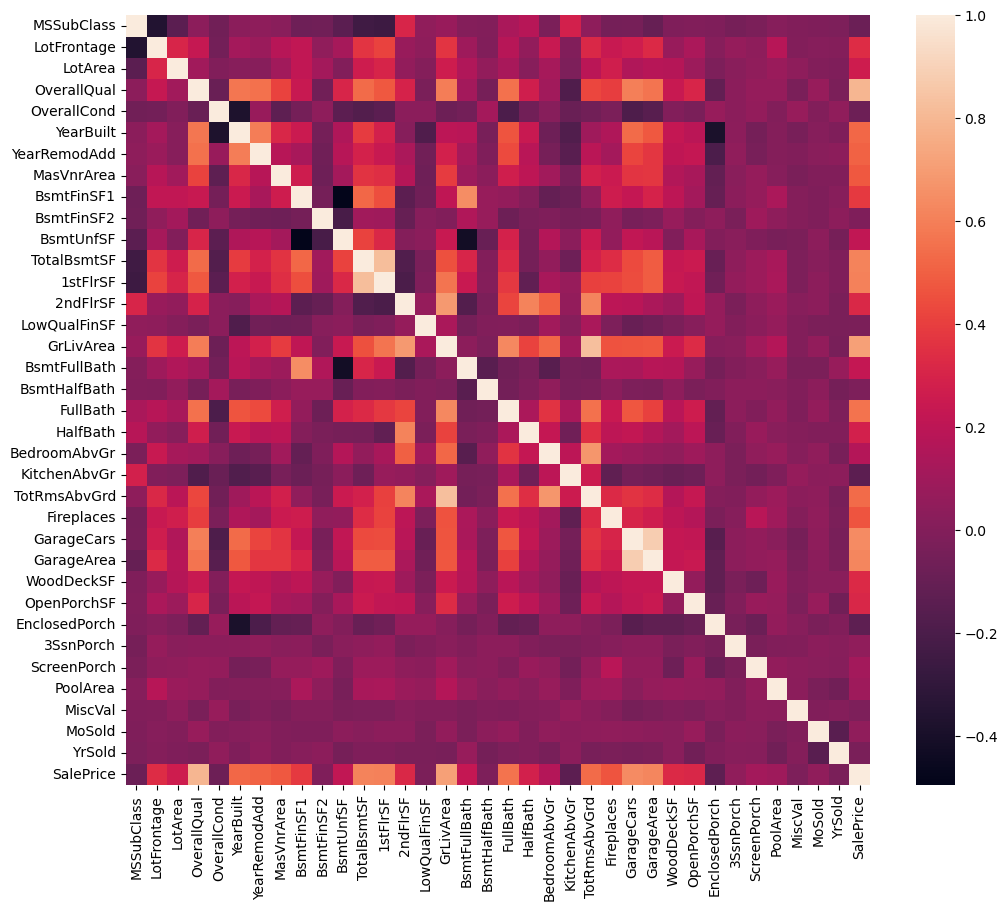

In [55]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f")
plt.show()

### Visualize Distributions and Correlations

## Data Preprocessing

### Handling Missing Datas (Imputation)

### Encode categorical variables

### Scale or normalize numerical features if needed.

# 3. Feature Engineering

# 4. Data Splitting

# 5. Model Selection and Training

# 6. Model Evaluation

# 7. Hyperparameter Tuning (Optional)

# 8. Final Model Training and Predictions

# 9. Conclusion

In [1]:
import pandas as pd
import numpy as np

In [2]:
test_data = pd.read_csv('data_downloaded/test.csv')
test_data

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]